# Download competition data

(unnecessary in kaggle)

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [ ]:
!kaggle competitions download -cq tabular-playground-series-mar-2022

!unzip -q train.csv.zip
!rm train.csv.zip

# Solution

## Import libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



## Load data

* train.csv - the training set, comprising measurements of traffic congestion across __65 roadways__ from April through September of 1991.
  * row_id - a unique identifier for this instance
  * time - the 20-minute period in which each measurement was taken
  * x - the east-west midpoint coordinate of the roadway
  * y - the north-south midpoint coordinate of the roadway
  * direction - the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.
  * congestion - congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.
* test.csv - the test set; you will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of __1991-09-30__.
* sample_submission.csv - a sample submission file in the correct format

In [25]:
train = pd.read_csv("train.csv", index_col="row_id", parse_dates=["time"])
test = pd.read_csv("test.csv", index_col="row_id", parse_dates=["time"])
submission = pd.read_csv("sample_submission.csv", index_col="row_id")

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848835 entries, 0 to 848834
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        848835 non-null  datetime64[ns]
 1   x           848835 non-null  int64         
 2   y           848835 non-null  int64         
 3   direction   848835 non-null  object        
 4   congestion  848835 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 38.9+ MB


In [28]:
train.head(5)

,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01,0,0,EB,70
1,1991-04-01,0,0,NB,49
2,1991-04-01,0,0,SB,24
3,1991-04-01,0,1,EB,18
4,1991-04-01,0,1,NB,60


In [40]:
print(train['direction'].unique())
print(test['direction'].unique())

['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']
['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']


In [39]:
print(train['x'].unique(), train['y'].unique())
print(test['x'].unique(), test['y'].unique())

[0 1 2] [0 1 2 3]
[0 1 2] [0 1 2 3]


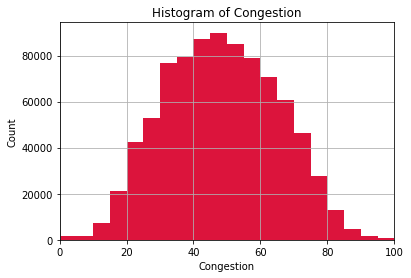

In [83]:
n, bins, patches = plt.hist('congestion', data=train, bins=20, color='crimson')


plt.xlabel('Congestion')
plt.ylabel('Count')
plt.title('Histogram of Congestion')
plt.xlim(0, 100)
plt.grid(True)
plt.show()

## Data engineering

In [47]:
train['road'] = train[['x','y','direction']].apply(tuple, axis=1)
train.head(5)

,time,x,y,direction,congestion,road
row_id,,,,,,
0,1991-04-01,0,0,EB,70,"(0, 0, EB)"
1,1991-04-01,0,0,NB,49,"(0, 0, NB)"
2,1991-04-01,0,0,SB,24,"(0, 0, SB)"
3,1991-04-01,0,1,EB,18,"(0, 1, EB)"
4,1991-04-01,0,1,NB,60,"(0, 1, NB)"


In [52]:
roads = {i:c for i,c in enumerate(train.road.unique())}
rev_roads = {c:i for i,c in enumerate(train.road.unique())}

In [86]:
train['road_id'] = [rev_roads[r] for r in train.road]
train.tail(10)

,time,x,y,direction,congestion,road,road_id
row_id,,,,,,,
848825,1991-09-30 11:40:00,2,2,SB,64,"(2, 2, SB)",55
848826,1991-09-30 11:40:00,2,2,SE,40,"(2, 2, SE)",56
848827,1991-09-30 11:40:00,2,2,SW,51,"(2, 2, SW)",57
848828,1991-09-30 11:40:00,2,2,WB,71,"(2, 2, WB)",58
848829,1991-09-30 11:40:00,2,3,EB,48,"(2, 3, EB)",59
848830,1991-09-30 11:40:00,2,3,NB,54,"(2, 3, NB)",60
848831,1991-09-30 11:40:00,2,3,NE,28,"(2, 3, NE)",61
848832,1991-09-30 11:40:00,2,3,SB,68,"(2, 3, SB)",62
848833,1991-09-30 11:40:00,2,3,SW,17,"(2, 3, SW)",63


Every locations are at least an intersection

In [71]:
for group_key, group_value in train.groupby(['x', 'y']):
  print(group_key, group_value['direction'].unique())

(0, 0) ['EB' 'NB' 'SB']
(0, 1) ['EB' 'NB' 'SB' 'WB']
(0, 2) ['EB' 'NB' 'SB' 'WB']
(0, 3) ['EB' 'NB' 'NE' 'SB' 'SW' 'WB']
(1, 0) ['EB' 'NB' 'NE' 'SB' 'SW' 'WB']
(1, 1) ['EB' 'NB' 'SB' 'WB']
(1, 2) ['EB' 'NB' 'NE' 'SB' 'SW' 'WB']
(1, 3) ['EB' 'NB' 'NE' 'SB' 'SW' 'WB']
(2, 0) ['EB' 'NB' 'SB' 'WB']
(2, 1) ['EB' 'NB' 'NE' 'NW' 'SB' 'SE' 'SW' 'WB']
(2, 2) ['EB' 'NB' 'NE' 'NW' 'SB' 'SE' 'SW' 'WB']
(2, 3) ['EB' 'NB' 'NE' 'SB' 'SW' 'WB']
